## 자전거 대여량 예측

워싱턴 D.C 소재의 자전거 대여 스타트업 Capital Bikeshare의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표입니다.

사람들이 자전거를 대여하는데는 많은 요소가 관여되어 있을 겁니다. 가령 **시간(새벽보다 낮에 많이 빌리겠죠)**, **날씨(비가 오면 자전거를 대여하지 않을 겁니다), 근무일(근무 시간에는 자전거를 대여하지 않겠죠)** 등. 이런 모든 요소를 조합하여 워싱턴 D.C의 자전거 교통량을 예측해주세요.

## 데이터 설명

#### 파일 구조
- train.csv
    - 학습을 위하여 활용되는 데이터 셋입니다.
- test.csv
    - 평가를 위하여 제공되는 데이터 셋입니다.
- submission.csv
    - test.csv 파일을 예측한 결과를 submission 파일에 작성한 후 제출합니다.
    
#### 컬럼 구조
  * **datetime** - 시간. 연-월-일 시:분:초 로 표현합니다. (가령 2011-01-01 00:00:00은 2011년 1월 1일 0시 0분 0초)
  * **season** - 계절. 봄(1), 여름(2), 가을(3), 겨울(4) 순으로 표현합니다.
  * **holiday** - 공휴일. 1이면 공휴일이며, 0이면 공휴일이 아닙니다.
  * **workingday** - 근무일. 1이면 근무일이며, 0이면 근무일이 아닙니다.
  * **weather** - 날씨. 1 ~ 4 사이의 값을 가지며, 구체적으로는 다음과 같습니다.
    * 1: 아주 깨끗한 날씨입니다. 또는 아주 약간의 구름이 끼어있습니다.
    * 2: 약간의 안개와 구름이 끼어있는 날씨입니다.
    * 3: 약간의 눈, 비가 오거나 천둥이 칩니다.
    * 4: 아주 많은 비가 오거나 우박이 내립니다.
  * **temp** - 온도. 섭씨(Celsius)로 적혀있습니다.
  * **atemp** - 체감 온도. 마찬가지로 섭씨(Celsius)로 적혀있습니다.
  * **humidity** - 습도.
  * **windspeed** - 풍속.
  * **casual** - 비회원(non-registered)의 자전거 대여량.
  * **registered** - 회원(registered)의 자전거 대여량.
  * **count** - 총 자전거 대여랑. 비회원(casual) + 회원(registered)과 동일합니다.
  
  ## 프로젝트 구성
* 데이터 로드 (load data, train.csv, test.csv)
* 데이터 전처리 및 특성 공학 (train.csv, test.csv)
* 모델 생성 및 검증 (train.csv)
* 평가 데이터 예측 (test.csv)
* 결과 제출 및 점수 확인

## 제출 이력 및 순위 조회
[평가시스템](http://manage.jaen.kr)에 접속하여 확인 가능
> 로그인 -> 프로젝트 -> 자전거 대여량 예측 -> 리더보드

### 접속 정보
- ID : `test@sk.com`
- PWD : `HELLO`

## 환경 설정

In [1]:
project_name = "자전거 대여량 예측" # 프로젝트 이름
class_info = "15차수 A반" # 차수 정보
email = "oh.myeongseob@sk.com" # 회사 이메일을 넣어주세요. (~~~@sk.com)

## 모듈 설치 및 데이터 다운로드

In [2]:
!pip install mySUNI

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
from mySUNI import cds

In [4]:
cds.download_project(project_name, class_info, email)


프로젝트: 자전거 대여량 예측
파일 목록

submission.csv
- data/자전거 대여량 예측/submission.csv

test.csv
- data/자전거 대여량 예측/test.csv

train.csv
- data/자전거 대여량 예측/train.csv



## 모듈 import 

필요한 모듈을 import 합니다. 필요에 따라 추가 패키지를 load 할 수 있습니다.

In [233]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Data 경로 설정
DATA_DIR = 'data'

# train 데이터셋 로드 (train.csv)
train = pd.read_csv(os.path.join(DATA_DIR, project_name, 'train.csv'))
                                 
# test 데이터셋 로드 (test.csv)
test = pd.read_csv(os.path.join(DATA_DIR, project_name, 'test.csv'))

# submission 파일 로드 (submission.csv)
submission = pd.read_csv(os.path.join(DATA_DIR, project_name, 'submission.csv'))

2개의 데이터 셋트를 나누어 제공합니다.

1. train: 학습용 데이터 세트. 정답 값이라고 할 수 있는 `label` 값이 같이 제공됩니다.
2. test: 예측용 데이터 세트. 정답 값이 빠진 `feature` 들만 제공됩니다. 우리는 이 `feature`를 활용하여 예측을 진행합니다.
3. submission: 정답 제출용 데이터 세트. 주어진 형식에 맞춰 정답 값을 기입하고 제출합니다.

In [234]:
def calculation(t, w):
    return 35.74 + 0.6215 * t - 35.75 * w ** 0.16 + 0.4275 * t * w ** 0.16

In [235]:
train['datetime'] = pd.to_datetime(train['datetime'], infer_datetime_format=True)
train['year'] = train['datetime'].dt.year
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['weekday'] = train['datetime'].dt.weekday
train['quarter'] = train['datetime'].dt.quarter

train['temp_diff'] = train['atemp'] - train['temp']

train['temp_chg'] = train.temp.shift(1)
train['temp_chg'] = train['temp'] - train['temp_chg']
train['temp_chg'] = train.temp_chg.fillna(0)

train['atemp_chg'] = train.atemp.shift(1)
train['atemp_chg'] = train['atemp'] - train['atemp_chg']
train['atemp_chg'] = train.atemp_chg.fillna(0)

train['humidity_chg'] = train.humidity.shift(1)
train['humidity_chg'] = train['humidity'] - train['humidity_chg']
train['humidity_chg'] = train.humidity_chg.fillna(0)

train['windspeed_chg'] = train.windspeed.shift(1)
train['windspeed_chg'] = train['windspeed'] - train['windspeed_chg']
train['windspeed_chg'] = train.windspeed_chg.fillna(0)

train['weather_chg'] = train.weather.shift(1)
train['weather_chg'] = train['weather'] - train['weather_chg']
train['weather_chg'] = train.weather_chg.fillna(0)

# train.loc[(train['windspeed'] == 0.0), 'windspeed'] = train['windspeed'].mean()
train['temp_calc'] = calculation(train['temp'], train['windspeed'])
train['temp_calc_diff'] = train['atemp'] - train['temp_calc']


# train['windspeed'] =  np.log(train['windspeed'])
# train.loc[((train['windspeed'] == np.inf) | (train['windspeed'] == -np.inf)), 'windspeed'] = 0
train['hour'] =  np.expm1(train['hour'])
train['temp'] =  np.expm1(train['temp'])
train['atemp'] =  np.expm1(train['atemp'])

train = train.drop(train[train['humidity'] == 0.0].index)
train = train.reset_index()

In [236]:
test['datetime'] = pd.to_datetime(test['datetime'], infer_datetime_format=True)
test['year'] = test['datetime'].dt.year
test['hour'] = test['datetime'].dt.hour
test['month'] = test['datetime'].dt.month
test['weekday'] = test['datetime'].dt.weekday
test['quarter'] = test['datetime'].dt.quarter

test['temp_diff'] = test['atemp'] - test['temp']

test['temp_chg'] = test.temp.shift(1)
test['temp_chg'] = test['temp'] - test['temp_chg']
test['temp_chg'] = test.temp_chg.fillna(0)

test['atemp_chg'] = test.atemp.shift(1)
test['atemp_chg'] = test['atemp'] - test['atemp_chg']
test['atemp_chg'] = test.atemp_chg.fillna(0)

test['humidity_chg'] = test.humidity.shift(1)
test['humidity_chg'] = test['humidity'] - test['humidity_chg']
test['humidity_chg'] = test.humidity_chg.fillna(0)

test['windspeed_chg'] = test.windspeed.shift(1)
test['windspeed_chg'] = test['windspeed'] - test['windspeed_chg']
test['windspeed_chg'] = test.windspeed_chg.fillna(0)

test['weather_chg'] = test.weather.shift(1)
test['weather_chg'] = test['weather'] - test['weather_chg']
test['weather_chg'] = test.weather_chg.fillna(0)

# test.loc[(test['windspeed'] == 0.0), 'windspeed'] = test['windspeed'].mean()
test['temp_calc'] = calculation(test['temp'], test['windspeed'])
test['temp_calc_diff'] = test['atemp'] - test['temp_calc']

# test['windspeed'] =  np.log(test['windspeed'])
# test.loc[((test['windspeed'] == np.inf) | (test['windspeed'] == -np.inf)), 'windspeed'] = 0
test['hour'] =  np.expm1(test['hour'])
test['temp'] =  np.expm1(test['temp'])
test['atemp'] =  np.expm1(test['atemp'])

In [237]:
train.describe()

,index,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg,temp_calc,temp_calc_diff
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,...,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,5451.290685,2.509665,0.028627,0.680228,1.415409,3.241678e+14,3.714540e+16,62.011782,12.789784,36.090666,...,3.013991,2.509665,3.424414,0.000302,0.000139,0.007180,0.001472,0.000000,12.334281,11.329656
std,3139.758593,1.115241,0.166762,0.466409,0.630784,7.098702e+15,7.723194e+17,19.061721,8.164754,49.987574,...,2.006614,1.115241,1.567699,0.986302,1.332031,6.226341,5.679460,0.433776,16.562221,13.633632
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.270500e+00,1.138276e+00,8.000000,0.000000,0.000000,...,0.000000,1.000000,-23.140000,-10.660000,-20.455000,-55.000000,-43.998900,-2.000000,-24.871636,-31.963890
25%,2737.750000,2.000000,0.000000,0.000000,1.000000,1.132569e+06,1.727896e+07,47.000000,7.001500,4.000000,...,1.000000,2.000000,2.780000,-0.820000,-0.755000,-4.000000,-2.994900,0.000000,0.536178,12.622320
50%,5453.500000,3.000000,0.000000,1.000000,1.000000,7.999022e+08,3.367427e+10,62.000000,12.998000,17.000000,...,3.000000,3.000000,3.680000,0.000000,0.000000,0.000000,0.000000,0.000000,9.878529,15.366456
75%,8169.250000,4.000000,0.000000,1.000000,2.000000,2.488211e+11,3.084513e+13,77.000000,16.997900,49.000000,...,5.000000,4.000000,4.055000,0.820000,0.755000,4.000000,2.994900,0.000000,19.368217,18.329548
max,10885.000000,4.000000,1.000000,1.000000,4.000000,6.398435e+17,5.506247e+19,100.000000,56.996900,367.000000,...,6.000000,4.000000,8.045000,9.840000,16.670000,100.000000,36.997400,2.000000,60.202240,27.448592


In [157]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,month,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6.493000e+03,6493.000000,6493.000000,6493.000000,6493.000000,6.493000e+03,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,2011.503619,6.458089e+08,6.565070,3.007239,2.521177,3.392258,5.471606e-19,0.000350,0.001386,-0.002619,0.000000
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.500025,2.045545e+09,3.429462,1.997714,1.110662,1.290172,1.045026e+00,1.347817,6.236989,5.847853,0.432078
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,2011.000000,0.000000e+00,1.000000,0.000000,1.000000,-1.640000,-1.394000e+01,-14.395000,-59.000000,-31.999200,-2.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,2011.000000,4.024288e+02,4.000000,1.000000,2.000000,2.655000,-8.200000e-01,-0.755000,-4.000000,-3.001600,0.000000
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,2012.000000,1.627538e+05,7.000000,3.000000,3.000000,3.680000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,2012.000000,6.565997e+07,10.000000,5.000000,4.000000,4.055000,8.200000e-01,0.755000,4.000000,2.994900,0.000000
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,2012.000000,9.744803e+09,12.000000,6.000000,4.000000,11.075000,9.840000e+00,10.605000,49.000000,32.997500,2.000000


In [99]:
train.isna().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual           0
registered       0
count            0
year             0
hour             0
month            0
weekday          0
quarter          0
temp_diff        0
temp_chg         0
atemp_chg        0
humidity_chg     0
windspeed_chg    0
weather_chg      0
dtype: int64

In [100]:
train['windspeed'].value_counts()

0.000000    1313
2.197013    1120
2.398023    1057
2.564795    1042
1.946124    1034
2.708137     961
1.792293     872
2.833090     824
2.944502     676
2.995707     492
3.091170     372
3.178029     274
3.258200     235
3.332180     187
3.401284     111
3.434016      89
3.496432      80
3.555371      58
3.663580      27
3.610848      22
3.761214      12
3.713506      11
3.784165       8
3.828689       3
4.042997       2
3.871176       2
3.912065       1
3.951219       1
Name: windspeed, dtype: int64

In [101]:
train['hour'].value_counts()

4.851652e+08    456
1.202603e+06    456
8.886110e+06    456
3.584913e+09    456
3.269016e+06    456
1.627538e+05    456
2.415495e+07    456
9.744803e+09    456
4.424124e+05    456
6.565997e+07    456
1.318816e+09    456
1.784823e+08    456
1.095633e+03    455
2.202547e+04    455
8.102084e+03    455
0.000000e+00    455
2.979958e+03    455
5.987314e+04    455
4.024288e+02    455
1.718282e+00    454
1.474132e+02    452
6.389056e+00    448
5.359815e+01    442
1.908554e+01    433
Name: hour, dtype: int64

In [148]:
# train = train.drop(train[train['windspeed'] == 0.0].index)
train = train.drop(train[train['humidity'] == 0.0].index)
train = train.reset_index()

In [114]:
train['humidity'].value_counts()

88    368
94    324
83    316
87    289
70    259
     ... 
13      1
10      1
12      1
96      1
91      1
Name: humidity, Length: 89, dtype: int64

In [149]:
train.describe()

,index,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,month,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,...,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,5451.290685,2.509665,0.028627,0.680228,1.415409,20.239523,23.663937,62.011782,12.789784,36.090666,...,6.456465e+08,6.528627,3.013991,2.509665,3.424414,0.000302,0.000139,0.007180,0.001472,0.000000
std,3139.758593,1.115241,0.166762,0.466409,0.630784,7.796779,8.480258,19.061721,8.164754,49.987574,...,2.045269e+09,3.444208,2.006614,1.115241,1.567699,0.986302,1.332031,6.226341,5.679460,0.433776
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,8.000000,0.000000,0.000000,...,0.000000e+00,1.000000,0.000000,1.000000,-23.140000,-10.660000,-20.455000,-55.000000,-43.998900,-2.000000
25%,2737.750000,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,...,4.024288e+02,4.000000,1.000000,2.000000,2.780000,-0.820000,-0.755000,-4.000000,-2.994900,0.000000
50%,5453.500000,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,...,1.627538e+05,7.000000,3.000000,3.000000,3.680000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8169.250000,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,...,6.565997e+07,10.000000,5.000000,4.000000,4.055000,0.820000,0.755000,4.000000,2.994900,0.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,...,9.744803e+09,12.000000,6.000000,4.000000,8.045000,9.840000,16.670000,100.000000,36.997400,2.000000


In [137]:
train.loc[(train['windspeed'] == 0.0), 'windspeed'] = train['windspeed'].mean()

In [191]:
train.loc[(train['season'] != train['quarter'])]

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,...,hour,month,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg


In [139]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour,month,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,12.799395,3,...,0.000000e+00,1,5,1,4.555,0.00,0.000,0.0,0.0000,0.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,12.799395,8,...,1.718282e+00,1,5,1,4.615,-0.82,-0.760,-1.0,0.0000,0.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,12.799395,5,...,6.389056e+00,1,5,1,4.615,0.00,0.000,0.0,0.0000,0.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,12.799395,3,...,1.908554e+01,1,5,1,4.555,0.82,0.760,-5.0,0.0000,0.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,12.799395,0,...,5.359815e+01,1,5,1,4.555,0.00,0.000,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,...,1.784823e+08,12,2,4,4.115,0.00,0.000,0.0,2.0033,0.0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,...,4.851652e+08,12,2,4,2.665,-0.82,-2.270,7.0,-11.0014,0.0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,...,1.318816e+09,12,2,4,1.970,-0.82,-1.515,4.0,0.0000,0.0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12,...,3.584913e+09,12,2,4,3.485,0.00,1.515,0.0,-8.9981,0.0


In [170]:
train.loc[(train['humidity'] == 0.0), 'humidity'] = train['humidity'].mean()

In [171]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,hour,month,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,1.088600e+04,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,62.011529,12.799395,36.021955,155.552177,...,6.457578e+08,6.521495,3.013963,2.506614,3.424224,0.000301,0.000209,-0.001378,0.000827,0.000000
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.042449,8.164537,49.960477,151.039033,...,2.045428e+09,3.444373,2.004585,1.116174,1.566612,0.986057,1.332250,6.283598,5.681784,0.433761
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,8.000000,0.000000,0.000000,0.000000,...,0.000000e+00,1.000000,0.000000,1.000000,-23.140000,-10.660000,-20.455000,-93.000000,-43.998900,-2.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,...,4.024288e+02,4.000000,1.000000,2.000000,2.745000,-0.820000,-0.755000,-4.000000,-2.994900,0.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,...,1.627538e+05,7.000000,3.000000,3.000000,3.680000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,...,6.565997e+07,10.000000,5.000000,4.000000,4.055000,0.820000,0.755000,4.000000,2.994900,0.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,...,9.744803e+09,12.000000,6.000000,4.000000,8.045000,9.840000,16.670000,100.000000,36.997400,2.000000


In [8]:
# 평가 데이터 조회
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,weekday,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,1,3,0.705,0.0,0.000,0.0,0.0000
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,1,3,2.975,0.0,2.270,0.0,-26.0027
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,1,3,2.975,0.0,0.000,0.0,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,1,3,2.220,0.0,-0.755,0.0,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,1,3,2.220,0.0,0.000,0.0,0.0000


In [147]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,month,weekday,quarter,temp_diff,temp_chg,atemp_chg,humidity_chg,windspeed_chg,weather_chg
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6.493000e+03,6493.000000,6493.000000,6493.000000,6493.000000,6.493000e+03,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,2011.503619,6.458089e+08,6.565070,3.007239,2.521177,3.392258,5.471606e-19,0.000350,0.001386,-0.002619,0.000000
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.500025,2.045545e+09,3.429462,1.997714,1.110662,1.290172,1.045026e+00,1.347817,6.236989,5.847853,0.432078
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,2011.000000,0.000000e+00,1.000000,0.000000,1.000000,-1.640000,-1.394000e+01,-14.395000,-59.000000,-31.999200,-2.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,2011.000000,4.024288e+02,4.000000,1.000000,2.000000,2.655000,-8.200000e-01,-0.755000,-4.000000,-3.001600,0.000000
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,2012.000000,1.627538e+05,7.000000,3.000000,3.000000,3.680000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,2012.000000,6.565997e+07,10.000000,5.000000,4.000000,4.055000,8.200000e-01,0.755000,4.000000,2.994900,0.000000
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,2012.000000,9.744803e+09,12.000000,6.000000,4.000000,11.075000,9.840000e+00,10.605000,49.000000,32.997500,2.000000


In [62]:
test.loc[(test['windspeed'] == 0.0), 'windspeed'] = test['windspeed'].mean()
test.loc[(test['humidity'] == 0.0), 'humidity'] = test['humidity'].mean()

In [92]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,weekday
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,11.555367,6.565070,3.007239
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,6.912526,3.429462,1.997714
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,6.000000,4.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,12.000000,7.000000,3.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,18.000000,10.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,23.000000,12.000000,6.000000


In [283]:
# features = [
#     'year',
#     'quarter',
# #     'month',
#     'weekday',
#     'hour',
#     'season',
#     'holiday',
#     'workingday',
#     'weather',
#     'temp',
#     'atemp',
#     'temp_diff',
#     'humidity',
#     'windspeed',
#     'weather_chg',
#     'temp_chg',
#     'atemp_chg',
#     'humidity_chg',
#     'windspeed_chg',
# ]
features = [
    'season',
    'holiday',
    'workingday',
    'weather',
    'temp',
    'atemp',
    'humidity',
    'windspeed',
    'year',
    'hour',
#     'quarter',
#     'temp_diff',
#     'month',
#     'temp_calc',
#     'temp_calc_diff',
    'weekday',
    'temp_chg',
#     'atemp_chg',
    'humidity_chg',
#     'windspeed_chg',
    'weather_chg',
]

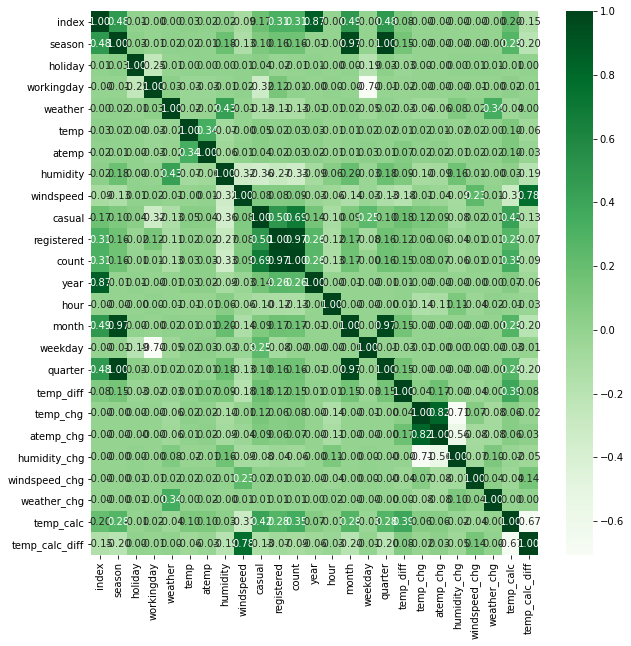

In [227]:

plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='Greens')
plt.show()

In [243]:
# train.drop(['datetime', 'casual', 'registered', 'atemp'], axis='columns', inplace=True)
X = train[features]
Y = train['count']

In [244]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10864 non-null  int64  
 1   holiday     10864 non-null  int64  
 2   workingday  10864 non-null  int64  
 3   weather     10864 non-null  int64  
 4   temp        10864 non-null  float64
 5   atemp       10864 non-null  float64
 6   humidity    10864 non-null  int64  
 7   windspeed   10864 non-null  float64
 8   year        10864 non-null  int64  
 9   hour        10864 non-null  float64
 10  weekday     10864 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 933.8 KB


In [18]:
import numpy as np
# 데이터 변환 (preprocessing) 과정에 존재 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
P = PolynomialFeatures(degree=3, include_bias=False)
x_poly = P.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(x_poly, Y, test_size=0.3, random_state=0)

from sklearn.linear_model import Ridge

# 극단적인 alpha 값 부여
model = Ridge(alpha=1000000000).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.4723194274444106, 0.4591581581574292)

In [27]:
from sklearn.linear_model import SGDRegressor
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# 확률적 경사하강법 모델 사용 
model = SGDRegressor(max_iter=10000, random_state=0).fit(x_train, y_train)

# Model 성능 표현 평가
model.score(x_train, y_train), model.score(x_test, y_test)

(0.2814613485345493, 0.28670963071967903)

In [26]:
P = PolynomialFeatures(degree=3, include_bias=False)
x_poly = P.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(x_poly, Y, random_state=0)

from sklearn.linear_model import Ridge

# 극단적인 alpha 값 부여
model = Ridge(alpha=1000000000).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.42690495979056176, 0.425825285476628)

In [37]:
X

,year,quarter,weekday,hour,season,holiday,workingday,weather,temp,atemp,temp_diff,humidity,windspeed,weather_chg,temp_chg,atemp_chg,humidity_chg,windspeed_chg
0,2011,1,5,0.000000e+00,1,0,0,1,9.84,14.395,4.555,81,-inf,0.0,0.00,0.000,0.0,0.0000
1,2011,1,5,1.718282e+00,1,0,0,1,9.02,13.635,4.615,80,-inf,0.0,-0.82,-0.760,-1.0,0.0000
2,2011,1,5,6.389056e+00,1,0,0,1,9.02,13.635,4.615,80,-inf,0.0,0.00,0.000,0.0,0.0000
3,2011,1,5,1.908554e+01,1,0,0,1,9.84,14.395,4.555,75,-inf,0.0,0.82,0.760,-5.0,0.0000
4,2011,1,5,5.359815e+01,1,0,0,1,9.84,14.395,4.555,75,-inf,0.0,0.00,0.000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,4,2,1.784823e+08,4,0,1,1,15.58,19.695,4.115,50,3.258200,0.0,0.00,0.000,0.0,2.0033
10882,2012,4,2,4.851652e+08,4,0,1,1,14.76,17.425,2.665,57,2.708137,0.0,-0.82,-2.270,7.0,-11.0014
10883,2012,4,2,1.318816e+09,4,0,1,1,13.94,15.910,1.970,61,2.708137,0.0,-0.82,-1.515,4.0,0.0000
10884,2012,4,2,3.584913e+09,4,0,1,1,13.94,17.425,3.485,61,1.792293,0.0,0.00,1.515,0.0,-8.9981


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
model = LinearRegression().fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.3182371320180919, 0.3293518122665058)

In [54]:
# 회귀모델 
from sklearn.tree import DecisionTreeRegressor
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    random_state=0)
model = DecisionTreeRegressor().fit(x_train, y_train)
# R2 나옴
model.score(x_train, y_train), model.score(x_test, y_test)


(0.9999999981342822, 0.8508824069383787)

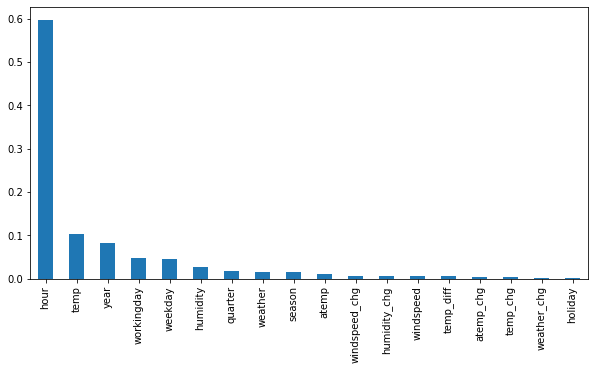

In [44]:
import pandas as pd
fi = pd.Series(model.feature_importances_, index=features)
fi[fi!=0].sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))

In [19]:
#과거 1등
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

params = {
    'max_depth' : range(1, 20, 1),
}
gs = GridSearchCV(model, params, cv=5).fit(X, Y)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head(5)
print(gs.best_params_)
model = RandomForestRegressor(**gs.best_params_).fit(X, Y)
model.score(X, Y)

{'max_depth': 17}


0.9903091696248265

In [23]:
#과거 1등 #현재까지 제일 좋음 = > 0.9919904758317128 / {'max_depth': 19}
X = train[features]
Y = np.log(train['count'])

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()


params = {
    'max_depth' : range(1, 20, 1),
}
gs = GridSearchCV(model, params, cv=5).fit(X, Y)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head(5)
print(gs.best_params_)
model = RandomForestRegressor(**gs.best_params_).fit(X, Y)
model.score(X, Y)

{'max_depth': 19}


0.9919904758317128

In [24]:
submission['count'] = np.exp(model.predict(test[features]))# test.csv를 예측한 결과 대입
submission


,datetime,count
0,2011-01-20 00:00:00,12.773146
1,2011-01-20 01:00:00,4.763804
2,2011-01-20 02:00:00,2.656007
3,2011-01-20 03:00:00,2.644209
4,2011-01-20 04:00:00,2.081219
...,...,...
6488,2012-12-31 19:00:00,261.306659
6489,2012-12-31 20:00:00,195.902180
6490,2012-12-31 21:00:00,125.479971
6491,2012-12-31 22:00:00,112.244510


In [62]:
#과거 1등 현재까지 제일 좋음 = > {'max_depth': 21} # 0.9930194141490305 # {'max_depth': 13} # 0.9654749872923223
X = train[features]
Y1 = np.log1p(train['registered'])
Y2 = np.log1p(train['casual'])

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()

params = {
    'max_depth' : range(9, 26, 1),
}
gs = GridSearchCV(RandomForestRegressor(), params, cv=5).fit(X, Y1)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head(5)
print(gs.best_params_)
reg = RandomForestRegressor(**gs.best_params_).fit(X, Y1)
print(reg.score(X, Y1))

gs = GridSearchCV(RandomForestRegressor(), params, cv=5).fit(X, Y2)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head(5)
print(gs.best_params_)
cas = RandomForestRegressor(**gs.best_params_).fit(X, Y2)
print(cas.score(X, Y2))

{'max_depth': 25}
0.9918636860956419
{'max_depth': 9}
0.909306532383621


In [63]:
submission['count'] = np.expm1(reg.predict(test[features])) + np.expm1(cas.predict(test[features]))
submission

,datetime,count
0,2011-01-20 00:00:00,9.614665
1,2011-01-20 01:00:00,5.078242
2,2011-01-20 02:00:00,2.433385
3,2011-01-20 03:00:00,2.329961
4,2011-01-20 04:00:00,2.121193
...,...,...
6488,2012-12-31 19:00:00,292.138971
6489,2012-12-31 20:00:00,191.105301
6490,2012-12-31 21:00:00,129.514474
6491,2012-12-31 22:00:00,111.031277


In [284]:
#현재까지 제일 좋음 = > 0.9751550767392252, 0.9327852112264146=> 0.35872
# 파일을 저장하였습니다. 파일명: submission-05-10-12.csv
# 제출 여부 :success
# 오늘 제출 횟수 : 37
# 제출 결과:0.35872
X = train[features]
Y1 = np.log1p(train['registered'])
Y2 = np.log1p(train['casual'])

from xgboost import XGBRegressor

reg = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1, subsample=0.54, random_state=123).fit(X, Y1)
print(reg.score(X, Y1))
cas = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1, subsample=0.54, random_state=123).fit(X, Y2)
print(cas.score(X, Y2))

0.9751550767392252
0.9327852112264146


In [91]:
#오히려 위에 보다 결과가 더 안좋음0.9920207167980238 0.9776813802772077
X = train[features]
Y1 = np.log1p(train['registered'])
Y2 = np.log1p(train['casual'])

from xgboost import XGBRegressor

reg = XGBRegressor(n_estimators=10000, learning_rate=0.01, n_jobs=-1, subsample=0.54, random_state=123).fit(X, Y1)
print(reg.score(X, Y1))
cas = XGBRegressor(n_estimators=10000, learning_rate=0.01, n_jobs=-1, subsample=0.54, random_state=123).fit(X, Y2)
print(cas.score(X, Y2))

0.9920207167980238
0.9776813802772077


In [285]:
submission['count'] = np.expm1(reg.predict(test[features])) + np.expm1(cas.predict(test[features]))
submission

,datetime,count
0,2011-01-20 00:00:00,12.390079
1,2011-01-20 01:00:00,5.074503
2,2011-01-20 02:00:00,2.781042
3,2011-01-20 03:00:00,1.682283
4,2011-01-20 04:00:00,1.621584
...,...,...
6488,2012-12-31 19:00:00,203.416458
6489,2012-12-31 20:00:00,136.094254
6490,2012-12-31 21:00:00,112.885185
6491,2012-12-31 22:00:00,83.081612


In [26]:
#성능이 안좋음
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, test_size=0.2,
                                                    random_state=0)

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

# model = lgb.train(params,
#                        lgb_train,
#                        valid_sets=lgb_eval,
#                        num_boost_round=5000,
#                        early_stopping_rounds=100)

model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                  early_stopping_rounds=5)#early_stopping_rounds은 overrfitting을 방지하기 위해 사용함!

p_train = model.predict(x_train, num_iteration=model.best_iteration)
p_test = model.predict(x_test, num_iteration=model.best_iteration)

r2_score(y_train, p_train), r2_score(y_test, p_test)

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 8
[LightGBM] [Info] Start training from score 173.009133
[1]	valid_0's l2: 33234.6
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 32700.8
[3]	valid_0's l2: 32177.1
[4]	valid_0's l2: 31919.6
[5]	valid_0's l2: 31417.7
[6]	valid_0's l2: 31178.6
[7]	valid_0's l2: 30692.9
[8]	valid_0's l2: 30214.6
[9]	valid_0's l2: 29743.7
[10]	valid_0's l2: 29280
[11]	valid_0's l2: 28815.6
[12]	valid_0's l2: 28360.1
[13]	valid_0's l2: 27987.4
[14]	valid_0's l2: 27549.2
[15]	valid_0's l2: 27190.9
[16]	valid_0's l2: 26778
[17]	valid_0's l2: 26375
[18]	valid_0's l2: 25978
[19]	valid_0's l2: 25591.6
[20]	valid_0's l2: 25212.7
[21]	valid_0's l2: 24830.5
[22]	valid_0's l2: 24454.1
[23]	valid_0's l2: 

(0.7294708775988459, 0.7024380733086429)

In [118]:
test[features]

,hour,weekday,season,holiday,workingday,weather,temp,humidity,windspeed
0,0,3,1,0,1,1,10.66,56,26.0027
1,1,3,1,0,1,1,10.66,56,0.0000
2,2,3,1,0,1,1,10.66,56,0.0000
3,3,3,1,0,1,1,10.66,56,11.0014
4,4,3,1,0,1,1,10.66,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,19,0,1,0,1,2,10.66,60,11.0014
6489,20,0,1,0,1,2,10.66,60,11.0014
6490,21,0,1,0,1,1,10.66,60,11.0014
6491,22,0,1,0,1,1,10.66,56,8.9981


In [20]:
submission['count'] = model.predict(test[features])# test.csv를 예측한 결과 대입
# submission = submission.head(1)
# submission = submission.iloc[1]
submission

,datetime,count
0,2011-01-20 00:00:00,12.184402
1,2011-01-20 01:00:00,5.709000
2,2011-01-20 02:00:00,3.405119
3,2011-01-20 03:00:00,3.199978
4,2011-01-20 04:00:00,2.554778
...,...,...
6488,2012-12-31 19:00:00,302.291431
6489,2012-12-31 20:00:00,195.954860
6490,2012-12-31 21:00:00,137.235000
6491,2012-12-31 22:00:00,111.034485


In [153]:
submission.loc[submission['count'] < 0.0]

,datetime,count


In [30]:
submission['count'] = np.where(submission['count'] < 0.0, 0, submission['count'] )

In [76]:
submission.loc[submission['count'] < 0.0]

,datetime,count


# 순서대로 평가가 진행됩니다. 실행은 1회만 해주세요.

- 느리다고 중지 후 다시 평가 코드를 실행하는 경우 제출 과정에서 패널티가 발생할 수 있습니다. (제출 횟수 이슈 발생 가능)

In [286]:
cds.submit(submission) # 제출 파일 생성 및 결과 제출

파일을 저장하였습니다. 파일명: submission-05-10-12.csv
제출 여부 :success
오늘 제출 횟수 : 37
제출 결과:0.35872


# 축하드립니다. 모델의 성능을 개선하여 더 좋은 점수를 획득해보세요!
* 데이터 전처리 (preprocessing)를 통하여, 결측치 처리
* 데이터 시각화를 통하여 이상치 처리 및 특성 처리
* 학습 특성 추가 사용
* **모델 앙상블(model ensemble)**을 통해 예측 성능 향상